## GenJAX

In [1]:
import inspect
import os

import jax
import jax.numpy as jnp
import jax.tree_util as jtu
from jax import jit
from jax import lax
from jax import random
from jax.example_libraries import stax
from jax.random import PRNGKey
from numpyro import optim
from numpyro.examples.datasets import MNIST
from numpyro.examples.datasets import load_dataset
import matplotlib.pyplot as plt


import genjax
from genjax import dippl
from genjax import gensp
from genjax import select

import adevjax


RESULTS_DIR = os.path.abspath(
    os.path.join(os.path.dirname(inspect.getfile(lambda: None)), ".results")
)
os.makedirs(RESULTS_DIR, exist_ok=True)

hidden_dim = 10
z_dim = 400
learning_rate = 1.0e-3
batch_size = 32
num_epochs = 20


def encoder(hidden_dim, z_dim):
    return stax.serial(
        stax.Dense(hidden_dim, W_init=stax.randn()),
        stax.Softplus,
        stax.FanOut(2),
        stax.parallel(
            stax.Dense(z_dim, W_init=stax.randn()),
            stax.serial(stax.Dense(z_dim, W_init=stax.randn()), stax.Exp),
        ),
    )


def decoder(hidden_dim, out_dim):
    return stax.serial(
        stax.Dense(hidden_dim, W_init=stax.randn()),
        stax.Softplus,
        stax.Dense(out_dim, W_init=stax.randn()),
        stax.Sigmoid,
    )


# Define our gradient estimator using our loss language.
def svi_update(
    model,
    guide,
    optimizer,
):
    def _inner(key, encoder_params, decoder_params, data):
        img_chm = genjax.value_choice_map(
            genjax.choice_map({"image": data.reshape((28 * 28,))})
        )

        @adevjax.adev
        def elbo_loss(encoder_params, decoder_params):
            key = adevjax.grab_key()
            w_q, latent_chm = guide.random_weighted(key, encoder_params, img_chm)
            merged = gensp.merge(latent_chm, img_chm)
            key = adevjax.grab_key()
            w_p = model.estimate_logpdf(key, merged, decoder_params)
            return w_p - w_q

        # @dippl.loss
        # def vae_loss(encoder, decoder):
        #    tgt = gensp.target(model, (decoder, ), img_chm)
        #    key = adevjax.grab_key()
        #    w = dippl.iwae_importance(10, guide, (encoder, v_chm)).estimate_normalizing_constant(key, tgt)
        #    return w

        loss, (encoder_params_grad, decoder_params_grad,) = adevjax.E(
            elbo_loss
        ).value_and_grad_estimate(key, (encoder_params, decoder_params))

        return (encoder_params_grad, decoder_params_grad), loss

    def batch_update(key, svi_state, batch):
        encoder_params, decoder_params = optimizer.get_params(svi_state)
        sub_keys = jax.random.split(key, len(batch))
        (encoder_grads, decoder_grads), loss = jax.vmap(
            _inner, in_axes=(0, None, None, 0)
        )(sub_keys, encoder_params, decoder_params, batch)
        encoder_grads, decoder_grads = jtu.tree_map(
            lambda v: -1.0 * jnp.mean(v), (encoder_grads, decoder_grads)
        )
        svi_state = optimizer.update(
            (encoder_grads, decoder_grads),
            svi_state,  # just (encoder_params, decoder_params)
        )
        return svi_state, jnp.mean(loss)

    return batch_update


@jit
def binarize(rng_key, batch):
    return random.bernoulli(rng_key, batch).astype(batch.dtype)


encoder_nn_init, encoder_nn_apply = encoder(hidden_dim, z_dim)
decoder_nn_init, decoder_nn_apply = decoder(hidden_dim, 28 * 28)

# Model + guide close over the neural net apply functions.
@genjax.gen
def decoder_model(decoder_params):
    latent = genjax.tfp_mv_normal_diag(jnp.zeros(z_dim), jnp.ones(z_dim)) @ "latent"
    probs = decoder_nn_apply(decoder_params, latent)
    _ = genjax.tfp_bernoulli(probs) @ "image"


@genjax.gen
def encoder_model(encoder_params, chm):
    image = chm.get_leaf_value()["image"]
    μ, Σ_scale = encoder_nn_apply(encoder_params, image)
    _ = dippl.mv_normal_diag_reparam(μ, Σ_scale) @ "latent"


model = gensp.choice_map_distribution(decoder_model)
guide = gensp.choice_map_distribution(encoder_model)

adam = optim.Adam(learning_rate)
svi_updater = svi_update(model, guide, adam)
train_init, train_fetch = load_dataset(MNIST, batch_size=batch_size, split="train")
num_train, train_idx = train_init()
rng_key = PRNGKey(0)
encoder_init_key, decoder_init_key = random.split(rng_key)
_, encoder_params = encoder_nn_init(encoder_init_key, (784,))
_, decoder_params = decoder_nn_init(decoder_init_key, (z_dim,))
num_train, train_idx = train_init()


@jit
def epoch_train(svi_state, key1, key2, train_idx):
    def body_fn(carry, xs):
        idx, svi_state, loss = carry
        rng_key_binarize = random.fold_in(key1, idx)
        batch = binarize(rng_key_binarize, train_fetch(idx, train_idx)[0])
        updater_key = random.fold_in(key2, idx)
        svi_state, loss = svi_updater(updater_key, svi_state, batch)
        idx += 1
        return (idx, svi_state, loss), loss

    idx = 0
    (_, svi_state, _), losses = lax.scan(
        body_fn, (idx, svi_state, 0.0), None, length=num_train
    )
    return svi_state, losses


key = random.PRNGKey(314159)
key, sub_key = jax.random.split(key)
svi_state = adam.init((encoder_params, decoder_params))

2023-10-12 14:35:18.559713: W external/xla/xla/service/platform_util.cc:198] unable to create StreamExecutor for CUDA:0: failed initializing StreamExecutor for CUDA device ordinal 0: INTERNAL: failed call to cuDevicePrimaryCtxRetain: CUDA_ERROR_OUT_OF_MEMORY: out of memory; total memory reported: 25358630912
CUDA backend failed to initialize: INTERNAL: no supported devices found for platform CUDA (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


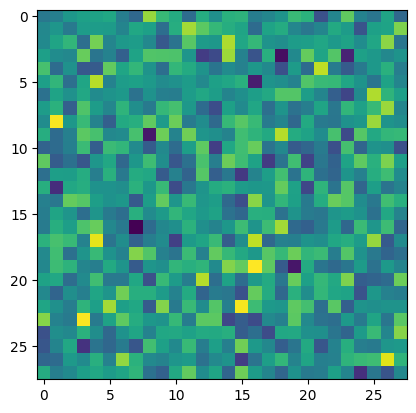

In [2]:
_, original_decoder_params = decoder_nn_init(decoder_init_key, (z_dim,))
key, sub_key = jax.random.split(key)
latent = genjax.tfp_mv_normal_diag.sample(sub_key, jnp.zeros(z_dim), jnp.ones(z_dim))
original_out = decoder_nn_apply(original_decoder_params, latent).reshape(28, 28)
plt.imshow(original_out)

-310.0816 -254.85023 -543.4047
-301.02094 -251.43846 -340.83936
-300.98233 -251.0455 -344.1284
-300.9488 -253.41164 -343.88882
-300.9627 -251.55702 -340.66336
-300.9022 -253.34378 -342.24728
-300.89697 -250.00449 -342.09384
-300.8692 -250.88121 -342.39343
-300.9064 -254.66641 -341.65143
-300.8312 -252.28136 -344.8117
-300.80283 -251.47952 -344.85773
-300.8208 -251.36827 -342.13745
-300.83133 -252.36458 -342.52493
-300.791 -248.50713 -342.54013
-300.76913 -254.39827 -344.0816
-300.82306 -252.3576 -341.25317
-300.8088 -253.38852 -344.77472
-300.76688 -250.70949 -345.16113
-300.80887 -252.38373 -341.26898
-300.82593 -252.3763 -344.0204


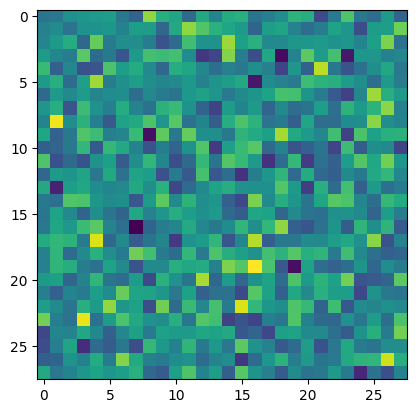

In [3]:
# Train.
for _ in range(0, num_epochs):
    key, key1, key2 = jax.random.split(key, 3)
    svi_state, loss = epoch_train(svi_state, key1, key2, train_idx)
    # print(loss)
    print(jnp.mean(loss), jnp.max(loss), jnp.min(loss))

_, updated_decoder_params = adam.get_params(svi_state)
updated_out = decoder_nn_apply(updated_decoder_params, latent).reshape(28, 28)
plt.imshow(updated_out)

-0.3723862


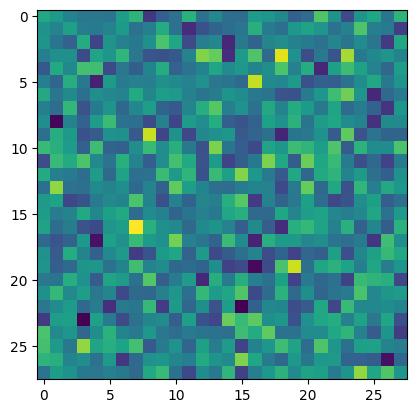

In [4]:
print(jnp.mean(updated_out - original_out))
plt.imshow(updated_out - original_out)

## Numpyro

In [5]:
import argparse
import inspect
import os
import time

import matplotlib.pyplot as plt

from jax import jit, lax, random
from jax.example_libraries import stax
import jax.numpy as jnp
from jax.random import PRNGKey

import numpyro
from numpyro import optim
import numpyro.distributions as dist
from numpyro.examples.datasets import MNIST, load_dataset
from numpyro.infer import SVI, Trace_ELBO


def model(batch, hidden_dim=400, z_dim=100):
    batch = jnp.reshape(batch, (batch.shape[0], -1))
    batch_dim, out_dim = jnp.shape(batch)
    decode = numpyro.module("decoder", decoder(hidden_dim, out_dim), (batch_dim, z_dim))
    with numpyro.plate("batch", batch_dim):
        z = numpyro.sample("z", dist.Normal(0, 1).expand([z_dim]).to_event(1))
        img_loc = decode(z)
        return numpyro.sample("obs", dist.Bernoulli(img_loc).to_event(1), obs=batch)


def guide(batch, hidden_dim=400, z_dim=100):
    batch = jnp.reshape(batch, (batch.shape[0], -1))
    batch_dim, out_dim = jnp.shape(batch)
    encode = numpyro.module("encoder", encoder(hidden_dim, z_dim), (batch_dim, out_dim))
    z_loc, z_std = encode(batch)
    with numpyro.plate("batch", batch_dim):
        return numpyro.sample("z", dist.Normal(z_loc, z_std).to_event(1))


encoder_nn = encoder(hidden_dim, z_dim)
decoder_nn = decoder(hidden_dim, 28 * 28)
adam = optim.Adam(learning_rate)
svi = SVI(model, guide, adam, Trace_ELBO(), hidden_dim=hidden_dim, z_dim=z_dim)
rng_key = PRNGKey(0)
train_init, train_fetch = load_dataset(MNIST, batch_size=batch_size, split="train")
test_init, test_fetch = load_dataset(MNIST, batch_size=batch_size, split="test")
num_train, train_idx = train_init()
rng_key, rng_key_binarize, rng_key_init = random.split(rng_key, 3)
sample_batch = binarize(rng_key_binarize, train_fetch(0, train_idx)[0])
svi_state = svi.init(rng_key_init, sample_batch)


@jit
def epoch_train(svi_state, rng_key, train_idx):
    def body_fn(i, val):
        loss_sum, svi_state = val
        rng_key_binarize = random.fold_in(rng_key, i)
        batch = binarize(rng_key_binarize, train_fetch(i, train_idx)[0])
        svi_state, loss = svi.update(svi_state, batch)
        loss_sum += loss
        return loss_sum, svi_state

    return lax.fori_loop(0, num_train, body_fn, (0.0, svi_state))


@jit
def eval_test(svi_state, rng_key, test_idx):
    def body_fun(i, loss_sum):
        rng_key_binarize = random.fold_in(rng_key, i)
        batch = binarize(rng_key_binarize, test_fetch(i, test_idx)[0])
        # FIXME: does this lead to a requirement for an rng_key arg in svi_eval?
        loss = svi.evaluate(svi_state, batch) / len(batch)
        loss_sum += loss
        return loss_sum

    loss = lax.fori_loop(0, num_test, body_fun, 0.0)
    loss = loss / num_test
    return loss


def reconstruct_img(epoch, rng_key):
    img = test_fetch(0, test_idx)[0][0]
    plt.imsave(
        os.path.join(RESULTS_DIR, "original_epoch={}.png".format(epoch)),
        img,
        cmap="gray",
    )
    rng_key_binarize, rng_key_sample = random.split(rng_key)
    test_sample = binarize(rng_key_binarize, img)
    params = svi.get_params(svi_state)
    z_mean, z_var = encoder_nn[1](
        params["encoder$params"], test_sample.reshape([1, -1])
    )
    z = dist.Normal(z_mean, z_var).sample(rng_key_sample)
    img_loc = decoder_nn[1](params["decoder$params"], z).reshape([28, 28])
    plt.imsave(
        os.path.join(RESULTS_DIR, "recons_epoch={}.png".format(epoch)),
        img_loc,
        cmap="gray",
    )


for i in range(num_epochs):
    rng_key, rng_key_train, rng_key_test, rng_key_reconstruct = random.split(rng_key, 4)
    t_start = time.time()
    num_train, train_idx = train_init()
    _, svi_state = epoch_train(svi_state, rng_key_train, train_idx)
    rng_key, rng_key_test, rng_key_reconstruct = random.split(rng_key, 3)
    num_test, test_idx = test_init()
    test_loss = eval_test(svi_state, rng_key_test, test_idx)
    reconstruct_img(i, rng_key_reconstruct)
    print("Epoch {}: loss = {} ({:.2f} s.)".format(i, test_loss, time.time() - t_start))

Epoch 0: loss = 206.91934204101562 (4.35 s.)
Epoch 1: loss = 196.79818725585938 (1.02 s.)
Epoch 2: loss = 185.83193969726562 (1.03 s.)
Epoch 3: loss = 176.07196044921875 (1.04 s.)
Epoch 4: loss = 168.4168701171875 (1.03 s.)
Epoch 5: loss = 160.6491241455078 (1.02 s.)
Epoch 6: loss = 157.64999389648438 (1.03 s.)
Epoch 7: loss = 153.6025848388672 (1.02 s.)
Epoch 8: loss = 148.94100952148438 (1.03 s.)
Epoch 9: loss = 146.85105895996094 (1.02 s.)
Epoch 10: loss = 143.2233123779297 (1.03 s.)
Epoch 11: loss = 143.20623779296875 (1.02 s.)
Epoch 12: loss = 143.14686584472656 (1.02 s.)
Epoch 13: loss = 142.47750854492188 (1.02 s.)
Epoch 14: loss = 142.02195739746094 (1.02 s.)
Epoch 15: loss = 141.4075469970703 (1.02 s.)
Epoch 16: loss = 141.5078582763672 (1.02 s.)
Epoch 17: loss = 141.3282928466797 (1.03 s.)
Epoch 18: loss = 141.4815673828125 (1.02 s.)
Epoch 19: loss = 141.30259704589844 (1.02 s.)


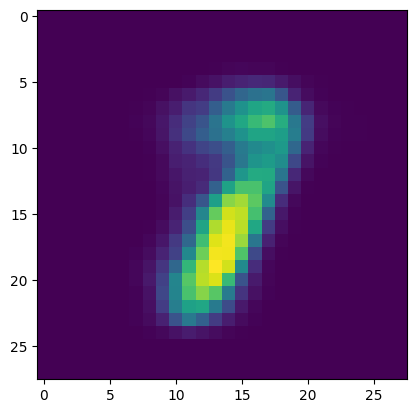

In [6]:
key, sub_key = jax.random.split(key)
z = dist.Normal(0, 1).expand([z_dim]).sample(sub_key)
params = svi.get_params(svi_state)
img_loc = decoder_nn[1](params["decoder$params"], z).reshape([28, 28])
plt.imshow(img_loc)